<h1>CS4619: Artificial Intelligence II</h1>
<h1>Recurrent Neural Networks</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [338]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping

In [342]:
df = pd.read_csv("../datasets/dataset_5000_reviews.csv")

In [343]:
# Dataset size
m = len(df)

# We'll keep only the 1000 most common words in the reviews.
vocab_size = 1000

# We'll truncate/pad so that each review has 200 words
maxlen = 200

In [344]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [345]:
# Train/test split
split_point = int(m * 0.8)
rest_of_X = padded_sequences[:split_point]
test_X = padded_sequences[split_point:] 

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(df["sentiment"])
rest_of_y = label_encoder.transform(df["sentiment"][:split_point])
test_y = label_encoder.transform(df["sentiment"][split_point:])

In [346]:
# Throughout the code, we will use 100-dimensional word embeddings (including the pretrained GloVe embeddings later)

embedding_dimension = 100

In [347]:
# Parse the GloVe word embeddings file: produces a dictionary from words to their vectors

path = "../datasets/glove.6B.100d.txt" # Edit this to point to your copy of the file

embeddings_index = {}
f = open(path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

In [348]:
# Create a matrix that associates the words that we obtained from the IMDB reviews earlier 
# (in the word_index) with their GloVe word embeddings

embedding_matrix = np.zeros((vocab_size, embedding_dimension)) 
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        word_embedding = embeddings_index.get(word)
        if word_embedding is not None:
            embedding_matrix[i] = word_embedding

<h1>Acknowledgements</h1>
<ul>
    <li>The diagrams are based closely on ones in: A. G&eacute;ron: 
        <i>Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (2nd edn)</i>, O'Reilly, 2019
    </li>
</ul>

<h1>Recurrent Neural Networks</h1>
<ul>
    <li>Up to now, we have looked at <b>feedforward</b> neural networks:
        <ul>
            <li>Activation flows in one direction: from input layer to output layer.</li>
        </ul>
    </li>
    <li>A <b>Recurrent Neural Network</b> (RNN) has connections that form directed cycles:
        <ul>
            <li>The output at one timestep becomes an input at the next time step.</li>
        </ul>
    </li>
    <li>RNNs can recognize patterns in <em>sequences</em> of data, such as text, speech, 
        genomes, clickstreams and timeseries data.
    </li>
    <li>The big difference between the previous lecture and the present one is this:
        <ul>
            <li>In the previous lecture, each document was a sequence but we flattened it.</li>
            <li>Here, we won't flatten. We will feed in each item from the sequence in turn.</li>
        </ul>
        But that's not all. We introduce the idea of state.
    </li>
</ul>

<h1>State</h1>
<ul>
    <li>Feedforward networks have no memory.
        <ul>
            <li>Consider presenting one of our examples $\v{x}_{(1)}, \v{x}_{(2)}, \ldots, \v{x}_{(\mathit{maxlen})}$
                to a feedforward network.
            </li>
            <li>We activate the network with the first input $\v{x}_{(1)}$.</li>
            <li>When we present the second input, $\v{x}_{(2)}$, the network has no memory of the first.</li>
            <li>Illustrative pseudocode:
                <ul style="background-color: lightgrey">
                    <li>for each $\v{x}_{(t)}$ in the example:
                        <ul>
                            <li>$\mbox{output} = f(\v{x}_{(t)})$</li>
                        </ul>
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>By contrast, a RNN maintains a <b>state</b>, containing information based on what it has seen so far.
        <ul>
            <li>Illustrative pseudocode:
                <ul style="background-color: lightgrey">
                    <li>$\mbox{state} = 0$</li>
                    <li>for each $\v{x}_{(t)}$ in the example:
                        <ul>
                            <li>$\mbox{output} = f(\v{x}_{(t)}, \mbox{state})$</li>
                            <li>$\mbox{state} = \mbox{output}$</li>
                        </ul>
                    </li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h1>A Recurrent Neuron</h1>
<ul>
    <li>Consider the simplest possible case: a single recurrent neuron:
        <figure>
            <img src="images/r_neuron.png" />
        </figure>
    </li>
    <li>Consider presenting it with a single example:
        <ul>
            <li>At each timestep $t$ (from $1\ldots \mbox{maxlen}$), it receives input vector $\v{x}_{(t)}$.</li>
            <li>Its output at time $t$ is a scalar (number), and this is fed back to itself at time $t+1$.</li>
        </ul>
    </li>
    <li>We can depict the behaviour of this recurrent neuron against time:
        <figure>
            <img src="images/r_neuron_t.png" />
        </figure>
        This is called <em>unrolling the network through time</em>.
    </li>
</ul>

<h2>Equations</h2>
<ul>
    <li>The recurrent neuron will have the following weights:
        <ul>
            <li>$\v{w}_x$ are the weights on the connections from the inputs, $\v{x}_{(t)}$.</li>
            <li>$w_a$ is the weight on the connection from the output of the previous step, 
                $a_{(t-1)}$.
            </li>
        </ul>
    </li>
    <li>So the output of this recurrent neuron is:
        $$a_{(t)} = g(\,\v{x}_{(t)}\v{w}_x + a_{(t-1)}w_a\,+ b\,)$$
    </li>
</ul>

<h2>Activation function</h2>
<ul>
    <li>In hidden RNN layers, the activation function $g$ can be ReLU but is often tanh:
        $$\mbox{tanh}(z) = \frac{\sinh(z)}{\cosh(z)} = \frac{( e^z - e^{-z} )}{( e^z + e^{-z} )}$$
    </li>
</ul>

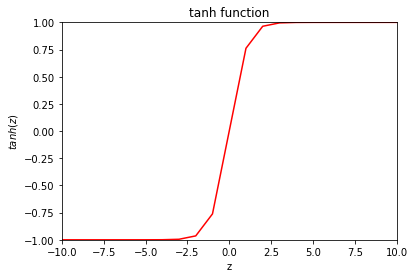

In [349]:
fig = plt.figure()
plt.title("tanh function")
xvals = np.linspace(-10, 10, 21)
plt.plot(xvals, np.tanh(xvals), color = "red")
plt.xlabel("z")
plt.xlim(-10, 10)
plt.ylabel("$tanh(z)$")
plt.ylim(-1.0, 1.0)
plt.show()

<h2>Output shape</h2>
<ul>
    <li>For this single recurrent neuron,
        <figure>
            <img src="images/r_neuron_t.png" />
        </figure>
        <ul>
            <li>Input shape is $(m, \mbox{maxlen}, n)$</li>
            <li>Output shape is $(m, \mbox{maxlen}, 1)$</li>
        </ul>
        This is where you want an output for every input in the sequence (i.e. one output per word).
    </li>
    <li>However, often we ignore all outputs except for the last one:
        <figure>
            <img src="images/r_neuron_t_ignore.png" />
        </figure>
        <ul>
            <li>Input shape is $(m, \mbox{maxlen}, n)$</li>
            <li>Output shape is $(m, 1)$</li>
        </ul>
        This is where you want an output for the entire sequence (i.e. one output per document), e.g. sentiment
        analysis.
    </li>
    <li>(When we're doing this in Keras, watch out for parameter <code>return_sequences</code> with
        values <code>True</code> or <code>False</code> (default)).
    </li>
</ul>

<h1>A RNN Layer</h1>
<ul>
    <li>More usual is a layer of several recurrent neurons:
        <figure>
            <img src="images/r_layer.png" />
        </figure>
    </li>
    <li>Consider presenting the layer with a single example:
        <ul>
            <li>At each timestep $t$ (from $1\ldots \mbox{maxlen}$), each neuron receives 
                input vector $\v{x}_{(t)}$.
            </li>
            <li>So we have a vector of outputs, $\v{a}_{(t)}$, containing the output of each neuron.</li>
            <li>The vector is fed back to each neuron at time $t+1$.</li>
        </ul>
    </li>
    <li>Here it is unrolled through time:
        <figure>
            <img src="images/r_layer_t.png" />
        </figure>
    </li>
</ul>   

<h2>Equations, again</h2>
<ul>
    <li>Now each recurrent neuron in the layer has two vectors of weights:
        <ul>
            <li>$\v{w}_x$ are the weights on the connections from the inputs, $\v{x}_{(t)}$.</li>
            <li>$\v{w}_a$ are the weights on the connections from the output of the previous step, 
                $\v{a}_{(t-1)}$.
            </li>
        </ul>
    </li>
    <li>So the output of a given recurrent neuron in the layer is:
        $$\v{a}_{(t)} = g(\,\v{x}_{(t)}\v{w}_x + \v{a}_{(t-1)}\v{w}_a\, + b\,)$$
    </li>
    <li>By introducing a lot of extra notation, we could write a vectorized form of the above
        to compute the outputs of all the neurons in the layer for all $m$ examples in
        a batch or mini-batch &mdash; but we won't bother here!
    </li>
</ul>

<h2>Output shape, again</h2>
<ul>
    <li>Let's refer to the number of recurrent neurons in the layer as '$\mbox{units}$'
        <figure>
            <img src="images/r_layer_t.png" />
        </figure>
        <ul>
            <li>Input shape is $(m, \mbox{maxlen}, n)$</li>
            <li>Output shape is $(m, \mbox{maxlen}, \mbox{units})$</li>
        </ul>
    </li>
    <li>However, often we ignore all outputs except for the last one
        <figure>
            <img src="images/r_layer_t_ignore.png" />
        </figure>
        <ul>
            <li>Input shape is $(m, \mbox{maxlen}, n)$</li>
            <li>Output shape is $(m, \mbox{units})$</li>
        </ul>
    </li>
</ul>

<h1>Backpropagation Through Time</h1>
<ul>
    <li>To train an RNN, we use an algorithm callled <b>Backpropagation Through Time</b> (BPTT).
        <ul>
            <li>Essentially, it is backprop on the unrolled network.</li>
            <li>But with the complication that weights are shared by all time steps in the unrolled network.</li>
        </ul>
    </li>
    <li>At a high-level, BPTT works as follows:
        <ul>
            <li><b>Random initialization</b>: initialize all weights randomly</li>
            <li><b>Forward propagation</b>: make predictions for all the training examples
            </li>
            <li><b>Backpropagation</b>: calculate error signals working back through the unrolled network</li>
            <li><b>Update all the weights</b>: the update to a weight is the sum of the updates made to that
                weight over all the time steps
            </li>
        </ul>
    </li>
</ul>

<h1>IMDB Reviews, Again</h1>

<ul>
    <li>We'll use pretrained word embeddings, although we could try one-hot encoding or we could learn our
        own embeddings.
    </li>
    <li>Note that we don't flatten. Instead, we have a recurrent layer.</li>
</ul>

In [375]:
def build_rnn(): 
    network = Sequential()
    network.add(Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension))
    # Load the pretrained word embeddings into the Embedding layer and freeze them
    network.layers[0].set_weights([embedding_matrix])
    network.layers[0].trainable = False
    network.add(SimpleRNN(embedding_dimension, activation="tanh", return_sequences=False))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["acc"])
    return network

In [376]:
rnn = build_rnn()

In [377]:
rnn.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 100)          100000    
_________________________________________________________________
simple_rnn_61 (SimpleRNN)    (None, 100)               20100     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 101       
Total params: 120,201
Trainable params: 20,201
Non-trainable params: 100,000
_________________________________________________________________


In [378]:
rnn_history = rnn.fit(rest_of_X, rest_of_y, epochs=10, batch_size=32, validation_split=0.25, 
                      callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

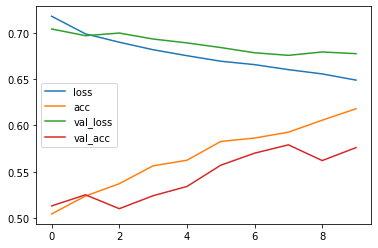

In [379]:
pd.DataFrame(rnn_history.history).plot()

<ul>
    <li>In the example, note that we have <code>return_sequences=False</code>. Why?</li>
    <li>In this next example, we will have two layers of recurrent neurons.
        <ul>
            <li>In the first, <code>return_sequences=True</code>. Why?</li>
            <li>In the second, <code>return_sequences=False</code>. Why?</li>
        </ul>
    </li>
</ul>

In [404]:
def build_more_complex_rnn(): 
    network = Sequential()
    network.add(Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension))
    # Load the pretrained word embeddings into the Embedding layer and freeze them
    network.layers[0].set_weights([embedding_matrix])
    network.layers[0].trainable = False
    network.add(SimpleRNN(embedding_dimension, activation="tanh", return_sequences=True))
    network.add(SimpleRNN(128, activation="tanh", return_sequences=False))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["acc"])
    return network

In [405]:
complex_rnn = build_more_complex_rnn()

In [406]:
complex_rnn.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 100)          100000    
_________________________________________________________________
simple_rnn_64 (SimpleRNN)    (None, 200, 100)          20100     
_________________________________________________________________
simple_rnn_65 (SimpleRNN)    (None, 124)               27900     
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 125       
Total params: 148,125
Trainable params: 48,125
Non-trainable params: 100,000
_________________________________________________________________


In [407]:
complex_rnn_history = complex_rnn.fit(rest_of_X, rest_of_y, epochs=10, batch_size=32, validation_split=0.25, 
                                      callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

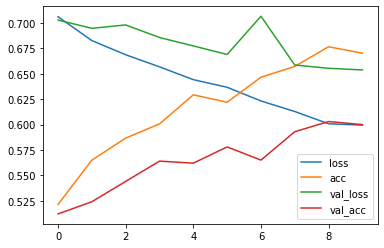

In [408]:
pd.DataFrame(complex_rnn_history.history).plot()

<h1>Long Sequences</h1>
<ul>
    <li>RNNs face two problems when input sequences are long:
        <ul>
            <li>Long training times!</li>
            <li>After a while, the <em>state</em> contains virtually no trace of the earliest inputs
                in the sequence.
                <ul>
                    <li>If we only need a memory of recent inputs to make a good prediction, then there's no problem.</li>
                    <li>But if there is a long-term dependency, then we have a problem.
                        <ul>
                            <li>E.g. Explain why it might be hard for such a network to predict the sentiment
                                of a movie review like this one: "I really don't think that this movie, despite
                                its fantastic cast, brilliant script-writer, and well-loved director, was very good."
                            </li>
                        </ul>
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>There are alternatives to simple recurrent neurons that are better at preserving longer term 
        memories:
        <ul>
            <li>LSTM neurons and GRUs.</li>
        </ul>
    </li>
</ul>

<h2>LSTM neurons and GRUs</h2>
<ul>
    <li><b>Long Short-Term Memory Neurons</b> (LSTM neurons):
        <ul>
            <li>The key idea is to have another vector of data, the <b>carry</b> $\v{c}_{(t)}$, to carry information
                across timesteps:
                <figure>
                    <img src="images/lstm_t.png" />
                </figure>
                <ul>
                    <li>At timestep $t$, the LSTM neuron has only quite limited ways to add
                        information to $c_{(t)}$ (or remove information from it) to
                        obtain $c_{(t+1)}$.
                    </li>       
                </ul>
            </li>
            <li>We won't go into the details.
                <ul>
                    <li>If interested, you could read this: 
                        <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">http://colah.github.io/posts/2015-08-Understanding-LSTMs/</a>.
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b>Gated Recurrent Units</b> (GRUs):
        <ul>
            <li>GRUs are simplified versions of LSTM neurons.</li>
            <li>They run a bit faster, yet often they are as accurate as using LSTM neurons.</li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>

In [409]:
def build_rnn_grus(): 
    network = Sequential()
    network.add(Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension))
    # Load the pretrained word embeddings into the Embedding layer and freeze them
    network.layers[0].set_weights([embedding_matrix])
    network.layers[0].trainable = False
    network.add(GRU(embedding_dimension, activation="tanh", return_sequences=True))
    network.add(GRU(128, activation="tanh", return_sequences=False))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["acc"])
    return network

In [410]:
rnn_grus = build_rnn_grus()

In [411]:
rnn_grus.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 100)          100000    
_________________________________________________________________
gru_10 (GRU)                 (None, 200, 100)          60600     
_________________________________________________________________
gru_11 (GRU)                 (None, 128)               88320     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
Total params: 249,049
Trainable params: 149,049
Non-trainable params: 100,000
_________________________________________________________________


In [412]:
grus_history = rnn_grus.fit(rest_of_X, rest_of_y, epochs=10, batch_size=32, validation_split=0.25, 
                            callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

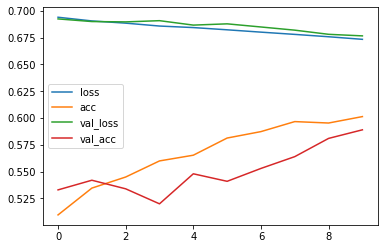

In [413]:
pd.DataFrame(grus_history.history).plot()

<h1>Overfitting in Recurrent Neural Networks</h1>
<ul>
    <li>We know lots of solutions but the one we'll discuss here is dropout.</li>
    <li>We could add a Dropout Layer before or after the GRU Layer but this may not help.
        <ul>
            <li>Dropout Layers before recurrent layers often hinder learning rather than
                helping with overfitting.
            </li>
            <li>The problem is that it can drop out different units for each
                input within the sequence.
            </li>
            <li>Instead, the same units should be dropped-out for each input within the sequence,
                while still being random between sequences.
            </li>
        </ul>
    </li>
    <li>In Keras, we can specify:
        <ul>
            <li><code>dropout</code>: roughly, the dropout rate on the inputs; and</li>
            <li><code>recurrent_dropout</code>: roughly, the dropout rate on the state.</li>
        </ul>
    </li>
</ul>

<h2>IMDB</h2>

In [414]:
def build_rnn_grus_dropout(): 
    network = Sequential()
    network.add(Embedding(input_dim=vocab_size, input_length=maxlen, output_dim=embedding_dimension))
    # Load the pretrained word embeddings into the Embedding layer and freeze them
    network.layers[0].set_weights([embedding_matrix])
    network.layers[0].trainable = False
    network.add(GRU(embedding_dimension, activation="tanh", return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    network.add(GRU(128, activation="tanh", return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    network.add(Dense(1, activation="sigmoid"))
    network.compile(optimizer=SGD(lr=0.01), loss="binary_crossentropy", metrics=["acc"])
    return network

In [415]:
rnn_grus_dropout = build_rnn_grus_dropout()

In [416]:
dropout_history = rnn_grus_dropout.fit(rest_of_X, rest_of_y, epochs=10, batch_size=32, validation_split=0.25, 
                                       callbacks=[EarlyStopping(monitor="val_loss", patience=2)], verbose=0)

<AxesSubplot:>

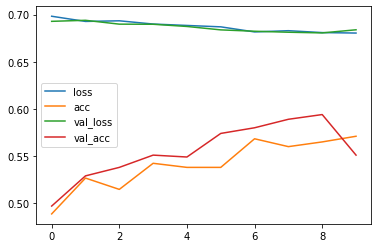

In [417]:
pd.DataFrame(dropout_history.history).plot()

<ul>
    <li>Let's say that our best effort was the RNN with two layers of GRUs but no dropout.</li>
    <li>Let's evaluate it on the test set.</li>
</ul>

In [418]:
test_loss, test_acc = rnn_grus.evaluate(test_X, test_y)
test_acc

32/32 [==============================] - 1s 27ms/step - loss: 0.6752 - acc: 0.5880


0.5879999995231628

<ul>
    <li>It is ironic (or even tragic) that all these clever ideas result, in this case, in a classifier
        whose accuracy is much, much lower than that which we obtained using bag-of-words.
    </li>
    <li>On the other hand, we have trained on just 5000 reviews.</li>
    <li>There are also lots of new ideas. For example, some people are using one-dimensional convolutional 
        neural networks for this kind of thing.
    </li>
</ul>